This script identifies the structures needed to compute the Climate Shelter Index (CSI), in particular:
- Surface Area of Green Spaces
- Presence of drinking fountains
- Presence of picnic tables and benches (rest area)

Each green area in the final dataset is public and free

### 0. Libraries

In [ ]:
# libraries
import os
import geopandas as gpd
import shapely  #1.8.5 version 
from shapely.geometry import Polygon
from shapely.geometry import Point
import matplotlib
import mapclassify
import rasterio
import numpy as np # 1.23.5 version
import pandas as pd
import urllib.request
import pyrosm

### 1. Surface Area 
Calculate the surface area of each public green space in the municipality of Bologna

In [ ]:
# Load the shapefile of 'unità gestionali'
un_gest = gpd.read_file(r"D:\Climate_Shelter_Index\unità_gestestionali_bologna\un_gest.shp")

In [ ]:
# Remove rows with empty geometries (if present)
un_gest = un_gest[un_gest['geometry'].notna()]

In [ ]:
# Check which categories are available 
un_gest.classe_unit.unique()

In [ ]:
# List of categories to exclude
categories_to_exclude = ['PARCHEGGIO', "VERDE D'ARREDO", "VERDE D'ARREDO STRADALE", 
                         'CORPO IDRICO (laghetti, ruscelli, e fossi in collina)']

# Filter to exclude the specified categories and keep all types of green areas
ar_vrd = un_gest[~un_gest['classe_unit'].isin(categories_to_exclude)]


In [ ]:
ar_vrd['area_prato'] = pd.to_numeric(ar_vrd['area_prato'], errors='coerce')

In [ ]:
# Calculate surface of green area in hectares
ar_vrd['area_Ha'] = ar_vrd['area_prato'] / 10000

In [ ]:
# Save the GeoDataFrame with the surface area as a shapefile
ar_vrd.to_file(r'D:\Climate_Shelter_Index\ar_vrd_surface.shp')

In [ ]:
ar_vrd.head(2)

### 2. Drinking fountains
Load data about drinking fountains

In [ ]:
url_download_bologna_pbf = 'https://osmit-estratti.wmcloud.org/dati/poly/comuni/pbf/037006_Bologna.osm.pbf'
urllib.request.urlretrieve(url_download_bologna_pbf ,"bologna_osm.pbf")
osm = pyrosm.OSM("bologna_osm.pbf") 

In [ ]:
# Identify drinking fountains using some filters
custom_filter = {'amenity': ['drinking_water']}
drinking_fountain = osm.get_pois(custom_filter=custom_filter)

In [ ]:
# Create a GeoDataFrame for drinking fountains
drinking_fountain_gdf = gpd.GeoDataFrame(drinking_fountain, geometry=[Point(x, y) for x, y in zip(drinking_fountain["lon"], drinking_fountain["lat"])])

In [ ]:
# Save the GeoDataFrame as a shapefile
drinking_fountain_gdf.to_file('D:\Climate_Shelter_Index\drinking_fountains.shp')

#### Green areas + Drinking fountains
Check if there are drinking fountains in the green areas

In [ ]:
# Load the shapefiles
green_area = gpd.read_file(r'D:\Climate_Shelter_Index\ar_vrd_surface.shp')
fountains = gpd.read_file(r"D:\Climate_Shelter_Index\drinking_fountains.shp")

In [ ]:
# Perform a spatial join to check if each park contains a fountain
ga_with_fountains = gpd.sjoin(green_area, fountains, how="left", op="intersects")

# Create a new column 'drinking_fountain' indicating if there is a fountain
ga_with_fountains["drinking_fountain"] = ga_with_fountains["index_right"].notnull().replace({True: "yes", False: "no"})

In [ ]:
# Create a new column 'id_fountain' with the ID of the drinking fountain if present
ga_with_fountains["id_fountain"] = ga_with_fountains["id"].fillna("N/A")

In [ ]:
# Select the columns you want to keep in the final GeoDataFrame
final_columns = ['quart', 'nome', 'ubicazione', 'classe_uni', 'classe_gia', 'classe_pen',
       'classe_suo', 'area_prato', 'area_ug', 'data_agg', 'siepi', 'bosco',
       'arboreo', 'arbustivo', 'pavim', 'idro', 'quartiere', 'area_stati',
       'zona_pross', 'area_Ha', 'geometry', 'drinking_fountain' ,'id_fountain']


In [ ]:
# Create a new GeoDataFrame with the selected columns
final_gdf = ga_with_fountains[final_columns]

final_gdf["id_fountain"] =  final_gdf["id_fountain"].apply(lambda x: str(x).replace('.0', '') if x != 'N/A' else x)


In [ ]:
# Rename the column
final_gdf.rename(columns={"drinking_fountain":"d_fountain",
                          "id_fountain":"id_df"
                          }, 
                 inplace=True)

In [ ]:
# Save the final GeoDataFrame as a shapefile
final_gdf.to_file(r"D:\Climate_Shelter_Index\ar_vrd_surface_drinkingfount.shp")


### 3. Picnic tables
Load data about picnic tables

In [ ]:
# Identify picnic tables using some filters
custom_filter = {'leisure': ['picnic_table']}
picnic_table = osm.get_pois(custom_filter=custom_filter)

In [ ]:
# Create a GeoDataFrame for picnic tables
picnic_table_gdf = gpd.GeoDataFrame(picnic_table, geometry=[Point(x, y) for x, y in zip(picnic_table["lon"], picnic_table["lat"])])

In [ ]:
# Save the GeoDataFrame as a shapefile
picnic_table_gdf.to_file('D:\Climate_Shelter_Index\picnic_tables.shp')

#### Green areas + Drinking fountains + Picnic tables
Check if there are picnic tables in the green areas

In [ ]:
# Load the shapefiles
ar_vrd_surface_drinkingfount = gpd.read_file(r"D:\Climate_Shelter_Index\ar_vrd_surface_drinkingfount.shp")
picnic_tables = gpd.read_file(r'D:\Climate_Shelter_Index\picnic_tables.shp')

In [ ]:
# Perform a spatial join to check if each park contains a picnic table
ga_pt = gpd.sjoin(ar_vrd_surface_drinkingfount, picnic_tables, how="left", op="intersects")

# Create a new column 'picnic_table' indicating if there is a picnic table
ga_pt["picnic_table"] = ga_pt["index_right"].notnull().replace({True: "yes", False: "no"})

In [ ]:
# Create a new column 'id_pt' with the ID of the picnic table if present
ga_pt["id_pt"] = ga_pt["id"].fillna("N/A")

In [ ]:
ga_pt.columns

In [ ]:
final_columns = ['quart', 'nome', 'ubicazione', 'classe_uni', 'classe_gia', 'classe_pen',
       'classe_suo', 'area_prato', 'area_ug', 'data_agg', 'siepi', 'bosco',
       'arboreo', 'arbustivo', 'pavim', 'idro', 'quartiere', 'area_stati',
       'zona_pross', 'area_Ha', 'd_fountain', 'id_df', 'geometry','picnic_table', 'id_pt']

# Create a new GeoDataFrame with the selected columns
final_gdf2 = ga_pt[final_columns]

final_gdf2['id_pt'] = final_gdf2['id_pt'].apply(lambda x: str(x).replace('.0', '') if x != 'N/A' else x)


In [ ]:
# Save the final GeoDataFrame as a shapefile
final_gdf2.to_file(r"D:\Climate_Shelter_Index\ar_vrd_s_df_pt.shp")

### 4. Benches
Load data about benches

In [ ]:
# Identify benches using some filters
custom_filter = {'amenity': ['bench']}
benches = osm.get_pois(custom_filter=custom_filter)

In [ ]:
# Create a GeoDataFrame for benches
benches_gdf = gpd.GeoDataFrame(benches, geometry=[Point(x, y) for x, y in zip(benches["lon"], benches["lat"])])

In [ ]:
# Save the GeoDataFrame as a shapefile
benches_gdf.to_file(r'D:\Climate_Shelter_Index\benches.shp')

#### Green areas + Drinking fountains + Picnic tables + Benches
Check if there are benches in the green areas

In [ ]:
# Load shapefiles
ar_vrd_s_df_pt = gpd.read_file(r"D:\Climate_Shelter_Index\ar_vrd_s_df_pt.shp")
benches = gpd.read_file(r'D:\Climate_Shelter_Index\benches.shp')

In [ ]:
# Perform a spatial join to check if each park contains benches
ga_benches = gpd.sjoin(ar_vrd_s_df_pt, benches, how="left", op="intersects")

# Create a new column 'benches' indicating if there is a bench
ga_benches["benches"] = ga_benches["index_right"].notnull().replace({True: "yes", False: "no"})

In [ ]:
# Create a new column 'id_bench' with the ID of the bench if present
ga_benches["id_bench"] = ga_benches["id"].fillna("N/A")

In [ ]:
ga_benches.columns

In [ ]:
final_columns = ['quart', 'nome', 'ubicazione', 'classe_uni', 'classe_gia', 'classe_pen',
       'classe_suo', 'area_prato', 'area_ug', 'data_agg', 'siepi', 'bosco',
       'arboreo', 'arbustivo', 'pavim', 'idro', 'quartiere', 'area_stati',
       'zona_pross', 'area_Ha', 'd_fountain', 'id_df', 'picnic_tab', 'id_pt',
       'geometry', 'benches', 'id_bench']

# Create a new GeoDataFrame with the selected columns
final_gdf3 = ga_benches[final_columns]

final_gdf3['id_bench'] = final_gdf3['id_bench'].apply(lambda x: str(x).replace('.0', '') if x != 'N/A' else x)


In [ ]:
# Save the final GeoDataFrame as a shapefile
final_gdf3.to_file(r"D:\Climate_Shelter_Index\ar_vrd_s_df_pt_b.shp")

In [48]:
final_gdf3.head()

,quart,nome,ubicazione,classe_uni,classe_gia,classe_pen,classe_suo,area_prato,area_ug,data_agg,...,area_stati,zona_pross,area_Ha,d_fountain,id_df,picnic_tab,id_pt,geometry,benches,id_bench
0,Borgo Panigale - Reno,GIARDINO MATERNA FUTURA,Via Tintoretto,VERDE SCOLASTICO,PIANO,0 -20%,NaN,2134.073,2626.432,2016-10-05,...,BATTINDARNO,BARCA,0.213407,no,N/A,no,N/A,"POLYGON ((11.29762 44.49943, 11.29766 44.49948...",no,N/A
1,Porto - Saragozza,GIARDINO MATERNA DOZZA,Viale Silvani,VERDE SCOLASTICO,PIANO,0 -20%,ARGILLOSO COMPATTO,1503.448,1911.187,2006-04-03,...,VELODROMO,SAFFI,0.150345,no,N/A,no,N/A,"POLYGON ((11.31213 44.50264, 11.31205 44.50265...",no,N/A
2,Savena,"G.NO CASA DI RIPOSO NOTTURNO ""MADRE TERESA DI ...",Viale Lenin 20,GIARDINO,PIANO,0 -20%,MEDIO IMPASTO,1431.556,1496.995,2006-11-19,...,FOSSOLO,FOSSOLO - DUE MADONNE,0.143156,no,N/A,no,N/A,"POLYGON ((11.38761 44.48887, 11.38786 44.48932...",no,N/A
3,Santo Stefano,GIARDINO DON TULLIO CONTIERO ( EX BELMELORO),Via Belmerolo,GIARDINO,PIANO,0 -20%,RICCO DI SCHELETRO,614.912,1010.221,2007-05-31,...,IRNERIO-2,IRNERIO,0.061491,no,N/A,no,N/A,"POLYGON ((11.35553 44.49509, 11.35539 44.49465...",no,N/A
4,Borgo Panigale - Reno,GIARDINO ERNESTO CHE GUEVARA,Via Battindarno,GIARDINO,PIANO,0 -20%,MEDIO IMPASTO,23.197,42.662,2016-11-21,...,BATTINDARNO,BARCA,0.002320,no,N/A,no,N/A,"POLYGON ((11.29749 44.50230, 11.29745 44.50231...",no,N/A


<Axes: >

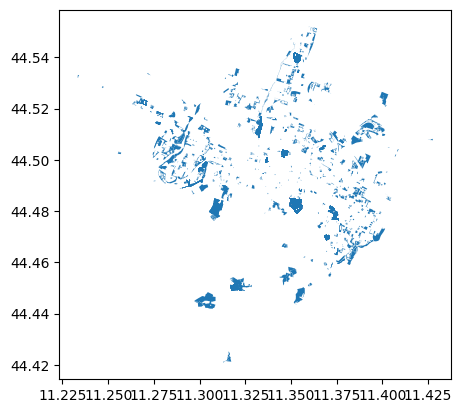

In [49]:
final_gdf3.plot()